In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

In [ ]:
## The steps to prepare a dataset for neural network training is shown in the diagram below

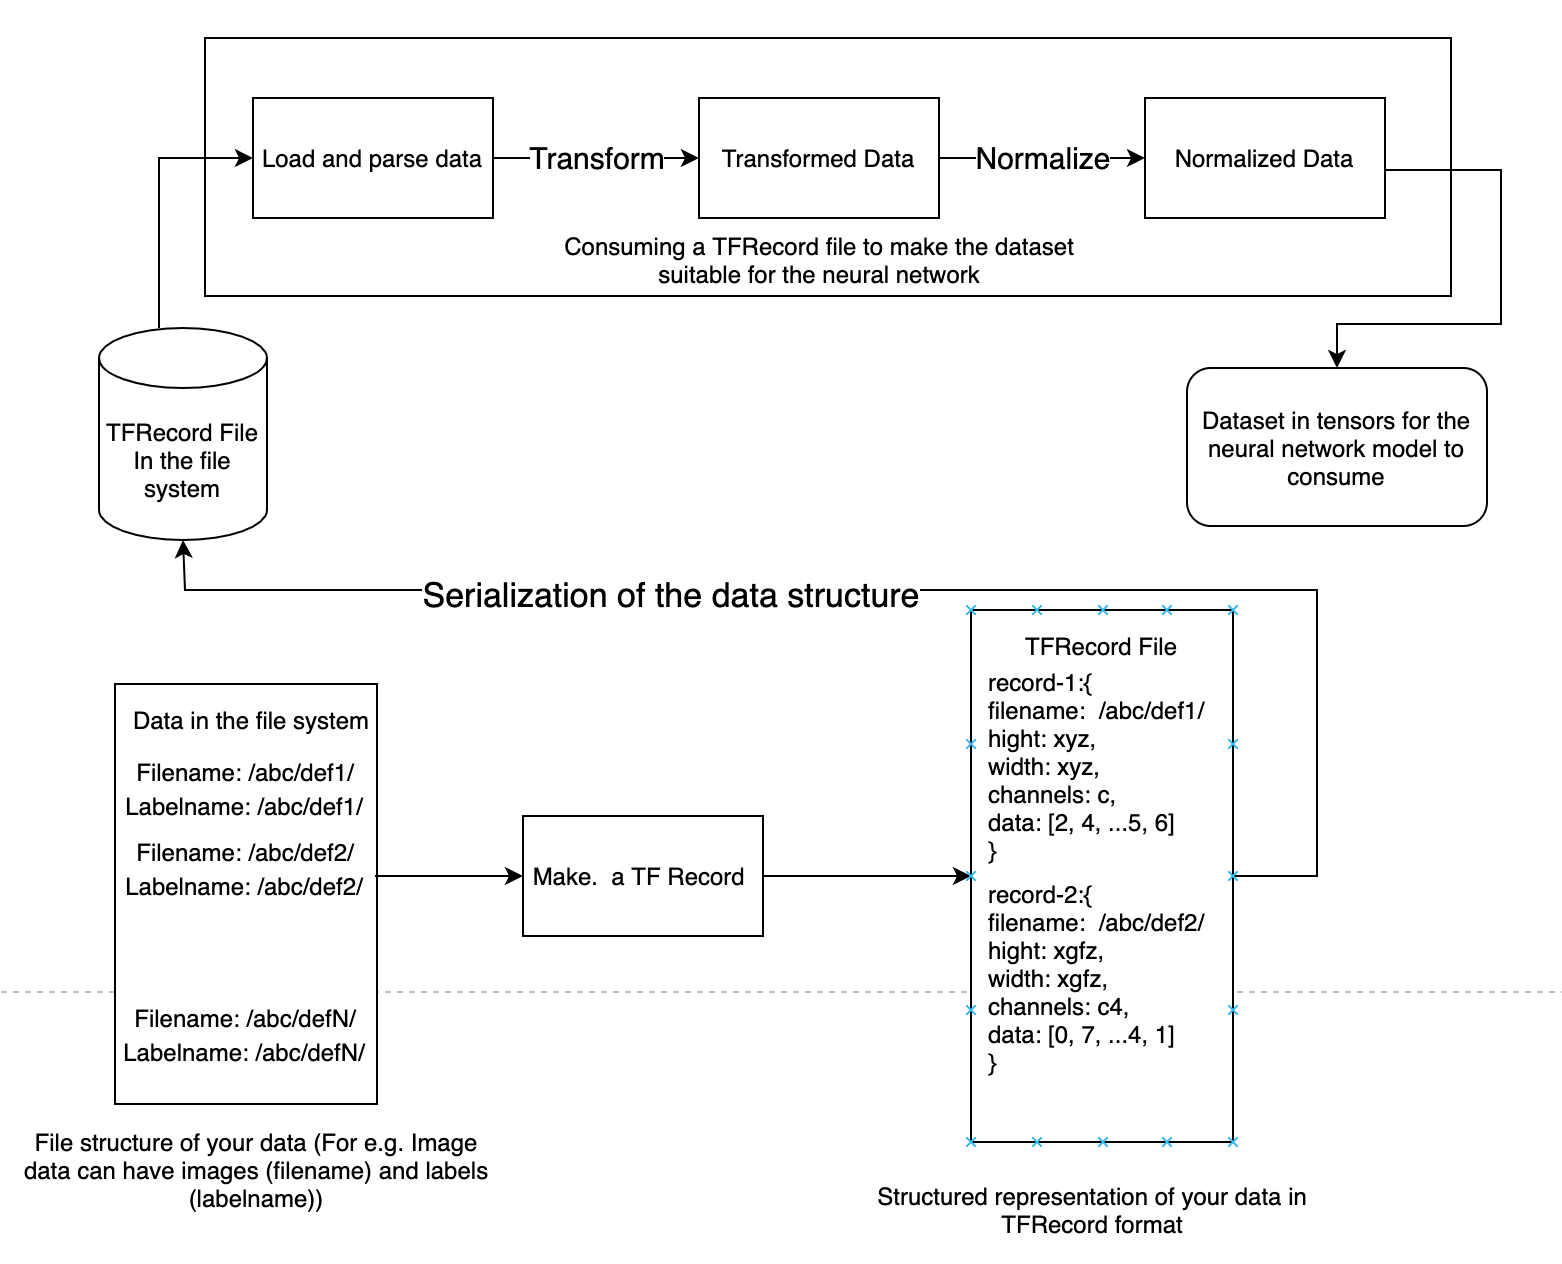

In [ ]:
## A simple answer on why serialze the data structures: https://www.quora.com/Why-do-we-serialize-data
## In short: Serialized bytes <--> [Encoder/Decoder in any language] <--> Data structure
## so basically storing data structures by serializing them standardize the data loading/streaming (The process becomes language independant)

In [ ]:
## tf.data Documentation: https://www.tensorflow.org/guide/data

In [ ]:
## Mout your google drive
from google.colab import drive
## mount location
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading CIFAR-10 data from the file system**

In [ ]:
## In case if your using the raw CIFAR 10 data use the unpickle to unpickle your
## serialized data stored in the file system:
## Ref to the function: https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
## The filepath where the cifar_10 data is  
## we are considering a part of the cifar-10 dataset (there are parts for each batch. Im taking one one batch file here)  
file_path = '/content/drive/My Drive/public_data/cifar_10/test/test_batch'
## The data is loaded as a python dictionary. A dictionary stores data in key,
## value pairs. 
## data = {
##    key1: (value1, value2),
##    key2: (value3, value4),
##}
## python dict: https://www.w3schools.com/python/python_dictionaries.asp
data_dict = unpickle(file_path)

#print(data_dict[b'labels']) ## values corresponds to labels key
#print(data_dict[b'filenames']) ## values corresponds to filenames key
#print(data_dict[b'data']) ## values corresponds to data key (images in (10000, 3072) matrix)
## 10000 is the number of images and 3072 is flat image vector. Image is 32x32x3
## 32 pix height, 32 pix width, 3 channels

**Loading CIFAR-10 data from the keras.datasets API**

In [ ]:
## If your loading from the datasets API itself, above steps are not required
train, test = tf.keras.datasets.cifar10.load_data()
## train: downladed neural network training data
## test: downloaded neural network testing data. Lets only focus on train data for now
## check the structure of the train variable
print(len(train)) ## length is 2
## so lets inspect each element
print(train[0].shape) ## (50000, 32, 32, 3): This looks like image data (number of samples, height, width, channels)
print(train[1].shape) ## (50000, 1): this looks like labels: (number of samples, object class) (CIFAR-10 has 10 classes, please read the Documentation)

170508288/170498071 [==============================] - 2s 0us/step
2
(50000, 32, 32, 3)
(50000, 1)


**LOADED AND UNPICKLED DATA VISUALIZATION**

(32, 32, 3)


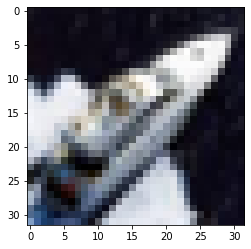

In [ ]:
## OK now, lets inspect the images. A primary inspection of the data is important so you can verify the data is loaded properly

## In the case of loaded and unpickled data:
## The documentation give you the guidline to use when rehaping the images
def reshape_cifar(image_vector):
  itr = 0
  image_reshaped = list()
  for c in range(3):
    img_slice = image_vector[itr:itr+1024]
    img_slice_mat = np.reshape(img_slice, (32, 32))
    image_reshaped.append(img_slice_mat)
    itr = itr + 1024
  
  return np.swapaxes(np.swapaxes(np.array(image_reshaped), 2, 0), 1, 0)

img = np.uint8(reshape_cifar(data_dict[b'data'][0]))
print(img.shape)
plt.imshow(img)

**Data loaded using keras.datasets API**

(32, 32, 3)


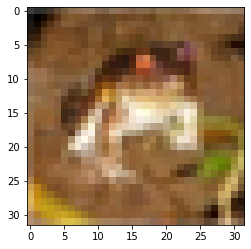

In [ ]:
## In the case of data loaded using keras.datasets API, The visualization is straight forward
img = np.uint8(np.array(train[0][0]))
print(img.shape)
plt.imshow(img)

In [ ]:
## Note that the inputs to these functions should be a scalar. No list or numpy ndarrays
## are accepted.
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

val = np.array(1)
## binarize the the val to a byte string
bin_val = val.tostring()
## Store a set of bytes in a data structure
print(_bytes_feature(bin_val))
## Store a set of int in a data structure
print(_int64_feature(val))
## Store a set of floats in a data structure
print(_float_feature(val))
## Now in the next step we will use this data type of data structure inside another
## data structure

bytes_list {
  value: "\001\000\000\000\000\000\000\000"
}

int64_list {
  value: 1
}

float_list {
  value: 1.0
}



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  app.launch_new_instance()


In [ ]:
## Now this function is defined to structure one image sample
def image_example(image_string, label, image_shape):
  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  ## the structure of the features now looks like
  ## features = {
  ##    'height': int64_list {
  ##                          value: height_val
  ##                          },
  ##    'width': int64_list {
  ##                          value: width_val
  ##                          },
  ##    'depth': int64_list {
  ##                          value: depth_val
  ##                          },
  ##    'label': int64_list {
  ##                          value: label_val
  ##                          },
  ##    'image_raw': byte_list {
  ##                          value: image_data
  ##                          },
  ##            }
  #print(feature)
  ## What the tf.train.Example does is, it converts the strctured features into
  ## a protocol buffer
  ## tf.train.Example protobuf doc: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/example.proto
  return tf.train.Example(features=tf.train.Features(feature=feature))


**Writing TFRecord when the dataset is loaded using keras.datasets API**

In [ ]:
## Now we have 
## 1. The image dataset in a dict (When loaded from a file system) or in a variable (when loaded using the keras.datasets API)
## 2. Functions to structure the data (To protobuf format)
## Now we can load the data from the dataset, structure them using image_example function and write to a TFRecord file

## The record file save name and path
record_file = '/content/drive/My Drive/public_data/cifar_10/cifar_10_data_dataset_api.tfrecords'
image_shape = [32, 32, 3]
## Open a TFRecordWriter in a contex manager (For more info on python contex management follow: https://www.geeksforgeeks.org/context-manager-in-python/)
with tf.io.TFRecordWriter(record_file) as writer:
    ## iterate over the  dataset (this is the case of keras.datasets API data)
    for data, lbl in zip(train[0], train[1]):
        ## convert the uint8 image data to a binary string for storage
        ## The reason is, as the functions accepts only scalars, not lists or nd arrays,
        ## we must convert the list/array to a string of bytes
        bin_data = data.tobytes('C')
        ## Make a tf example protobuf from the given binarized image data and labels
        tf_example = image_example(bin_data, lbl, image_shape)
        ## Write the serialized protobuf to record file
        writer.write(tf_example.SerializeToString())

**Writing TFRecord when the dataset is loaded from the file system**


In [ ]:
## Note here, since we are considering a part of the cifar-10 dataset (there are parts for each batch. Im taking one one batch file here) the
## TFRecord file will be smaller than the keas.datasets API TFRecord file
record_file = '/content/drive/My Drive/public_data/cifar_10/test/test_batch_from_fs.tfrecords'#
image_shape = [32, 32, 3]
# img = np.uint8(reshape_cifar(data))
# plt.imshow(img)
with tf.io.TFRecordWriter(record_file) as writer:
    ## together iterate using the data and labels keys (from the unpickled dict)
    for data, lbl in zip(data_dict[b'data'], data_dict[b'labels']):
      img = np.uint8(reshape_cifar(data))
      # plt.imshow(img)
      bin_data = img.tobytes('C')
      tf_example = image_example(bin_data, lbl, image_shape)
      writer.write(tf_example.SerializeToString())

In [ ]:
## Make multiple TF files
# Load the data files and dump each data file to tfrecord
folder_path = '/content/drive/My Drive/public_data/cifar_10/train_all'
file_list = glob.glob(os.path.join(folder_path, '*'))
print(file_list)
image_shape = [32, 32, 3]

for file_path in file_list:
  data_dict = unpickle(file_path)
  file_id = file_path.split('_')[-1]
  record_file = '.'.join(['/content/drive/My Drive/public_data/cifar_10/train_records/cifar_10_from_fs_' + str(file_id), 'tfrecords'])
  print("Writing record file: {}".format(record_file))
  with tf.io.TFRecordWriter(record_file) as writer:
    ## together iterate using the data and labels keys (from the unpickled dict)
    for data, lbl in zip(data_dict[b'data'], data_dict[b'labels']):
      img = np.uint8(reshape_cifar(data))
      # plt.imshow(img)
      bin_data = img.tobytes('C')
      tf_example = image_example(bin_data, lbl, image_shape)
      writer.write(tf_example.SerializeToString())

['/content/drive/My Drive/public_data/cifar_10/train_all/data_batch_3', '/content/drive/My Drive/public_data/cifar_10/train_all/data_batch_2', '/content/drive/My Drive/public_data/cifar_10/train_all/data_batch_5', '/content/drive/My Drive/public_data/cifar_10/train_all/data_batch_4', '/content/drive/My Drive/public_data/cifar_10/train_all/data_batch_1']
Writing record file: /content/drive/My Drive/public_data/cifar_10/train_records/cifar_10_from_fs_3.tfrecords
Writing record file: /content/drive/My Drive/public_data/cifar_10/train_records/cifar_10_from_fs_2.tfrecords
Writing record file: /content/drive/My Drive/public_data/cifar_10/train_records/cifar_10_from_fs_5.tfrecords
Writing record file: /content/drive/My Drive/public_data/cifar_10/train_records/cifar_10_from_fs_4.tfrecords
Writing record file: /content/drive/My Drive/public_data/cifar_10/train_records/cifar_10_from_fs_1.tfrecords


## **LOADING A SAVED TFRECORD FILE**

In [ ]:
## The path where the tf record file is
file_name = '/content/drive/My Drive/public_data/cifar_10/test/test_batch_from_fs.tfrecords'
## Load the raw tf record file from the file system
raw_image_dataset = tf.data.TFRecordDataset(file_name)
print(raw_image_dataset) ## gives no much information since the parsing of a tfrecord file is not yet implemented
## To parse a tfrecord file, one needs the structure of the record file (How the data is structured when they are saved)

<TFRecordDatasetV2 shapes: (), types: tf.string>


In [ ]:
## Make the structure that would help us to parse the TFRecord file
## feature descriptor dict
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [ ]:
## Now we make a function that an iterator can take as an higher oder function
def _parser_image_function(example_proto):
    ## Parse a single image feature structure
    ## serialized byte --> _parser_image_function(feature description) --> parsed image structure (see image_example function)
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [ ]:
## python map on an iterator example
def square_element(x):
  return x ** 2

a = np.arange(0, 10, 1)
print("Input Iterator {}".format(a))
b = list(map(lambda x: square_element(x), a))
print("Output Iterator {}".format(b))
## Note here the a havent changed. The mapping function produces a new list
## call the function by means of an iterator mapping. Please see the above mapping. Both works the same way
parsed_image_dataset = raw_image_dataset.map(_parser_image_function)

Input Iterator [0 1 2 3 4 5 6 7 8 9]
Output Iterator [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [ ]:
## Now we have access to the keys of the dataset data structure (keys are defined in the feature descreption dict).
## store images in a list (Only to debug (view and see the images))
image_list = list()
for image_features in parsed_image_dataset:
    ## image byte string --> tf.io.decode_raw --> tf.uint8 image tensor
    image_uint = tf.io.decode_raw(image_features['image_raw'], out_type=tf.uint8)
    ## get the labels as well (No need to decode because they are stored as int64 values)
    image_label = image_features['label']
    # print(image_label.numpy())
    ## append the decoded images to the list
    image_list.append(image_uint.numpy()) 

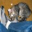

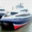

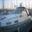

In [ ]:
## view some images
for i in range(3):
  image = image_list[i]
  display(Image.fromarray(np.reshape(image, (32, 32, 3))))
  print()